In [1]:
%matplotlib widget

In [21]:
import matplotlib.pyplot as plt
import numpy as np

import xtrack as xt
import xpart as xp

xt.enable_pyheadtail_interface()

In [22]:
# Import in Xsuite
line = xt.Line.from_json('./pimms_00_optics.json')
tw4d = line.twiss(method='4d')

Loading line from dict:   0%|          | 0/224 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [23]:
line.vars.get_table().rows['.*rf']

Table: 2 rows, 2 cols
name       value
vrf            0
frf            0

In [24]:
line.vars['vrf'] = 0.01 # MV
line.vars['frf'] = 1 / tw4d.T_rev0 / 1e6 # MHz, h=1

In [25]:
tw = line.twiss()

In [26]:
p = line.build_particles(zeta=np.linspace(0, tw.circumference/2, 20))

In [27]:
line.track(p, num_turns=2000, turn_by_turn_monitor=True, with_progress=True)

Tracking:   0%|          | 0/2000 [00:00<?, ?it/s]

In [28]:
mon = line.record_last_track

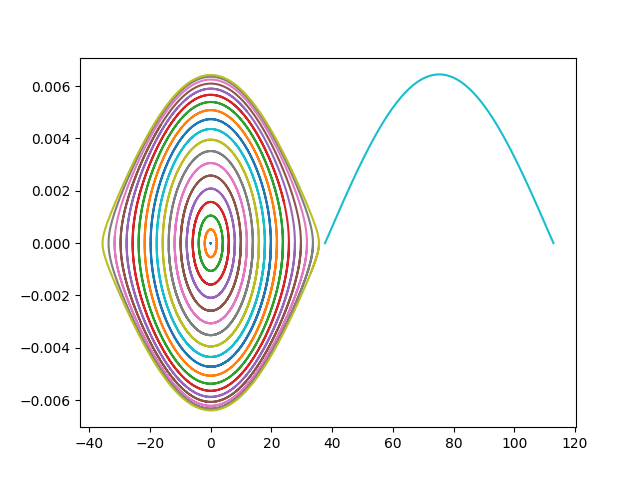

In [29]:
plt.figure()
plt.plot(mon.zeta.T, mon.delta.T);

In [30]:
from PyHEADTAIL.impedances import wakes
from PyHEADTAIL.particles.slicing import UniformBinSlicer


R_shunt = 10*10.2e6    # Shunt impedance [Ohm/m]
frequency = 1.3e6   # Resonance frequency [Hz]
Q = 1               # Quality factor

slices = 20
slicer_for_wakes = UniformBinSlicer(slices, n_sigma_z=6)

# Wake
wake = wakes.CircularResonator(R_shunt, frequency, Q)
wakefield = wakes.WakeField(slicer_for_wakes, wake)
wakefield.needs_hidden_lost_particles = True
line.discard_tracker()
line.append_element(name='wakefield', element=wakefield)
line.build_tracker()

Found suitable prebuilt kernel `default_only_xtrack`.


In [31]:
line.enable_time_dependent_vars = False
bunch = xp.generate_matched_gaussian_bunch(line=line,
    total_intensity_particles=1e11, nemitt_x=2e-6, nemitt_y=2e-6, sigma_z=10.,
    num_particles=1000)
bunch.circumference = tw.circumference

bunch0 = bunch.copy()

Ignoring collective elements in particles generation.


*** Maximum RMS bunch length 11.827306774060045m.
... distance to target bunch length: -1.0000e+01
... distance to target bunch length: 1.5294e+00
... distance to target bunch length: 1.4164e+00
... distance to target bunch length: -8.3951e-02
... distance to target bunch length: 1.3153e-01
... distance to target bunch length: 4.3249e-03
... distance to target bunch length: 1.3399e-04
... distance to target bunch length: -8.3374e-09
... distance to target bunch length: 2.0244e-05
--> Bunch length: 9.999999991662596


Ignoring collective elements in particles generation.


--> Emittance: 0.6118515375787399


In [32]:
bunch.x += 1e-3
track_log = xt.Log(x_mean=lambda line, bunch: bunch.x[bunch.state>0].mean()) 
line.enable_time_dependent_vars = True
line.track(bunch, log=track_log, num_turns=1000, with_progress=True)
x_mean = line.log_last_track['x_mean']

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

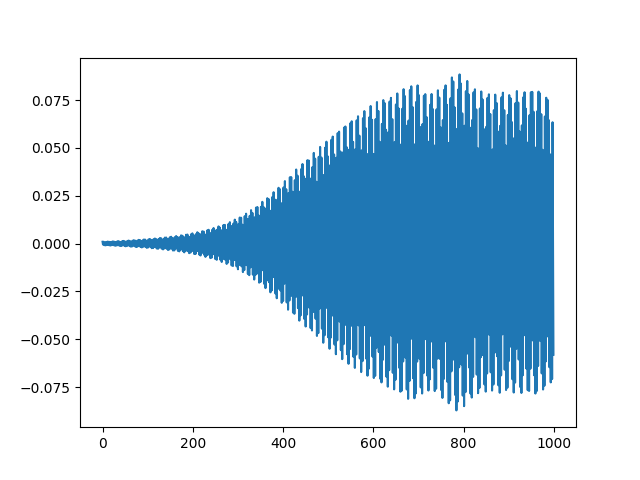

In [35]:
plt.figure()
plt.plot(x_mean)

In [36]:
line.enable_time_dependent_vars = False
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['ksf', 'ksd'], step=1e-3),
        xt.VaryList(['kqfa', 'kqfb'], limits=(0, 1),  step=1e-3, tag='qf'),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3, tag='qd'),
    ],
    targets=[
        xt.TargetSet(dqx=-2., dqy=-2., tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='extr_septum', tol=1e-6),
        xt.TargetSet(qx=1.64, qy=1.72, tol=1e-6),
    ]
)
opt.step(20)

The line has collective elements.
In the twiss computation collective elements are replaced by drifts
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
The line has collective elements.
In the twiss computation collective elements are replaced by drifts
The line has collective elements.       
In the twiss computation collective elements are replaced by drifts
The line has collective elements.       
In the twiss computation collective elements are replaced by drifts
The line has collective elements.       
In the twiss computation collective elements are replaced by drifts
The line has collective elements.       
In the twiss computation collective elements are replaced by drifts
The line has collective elements.       
In the twiss computation collective elements are replaced by drifts
The line has collective elements.       
In the twiss computation collective elements are

In [37]:
bunch = bunch0.copy()
bunch.circumference = tw.circumference

In [38]:
bunch.x += 1e-3
track_log = xt.Log(x_mean=lambda line, bunch: bunch.x[bunch.state>0].mean()) 
line.enable_time_dependent_vars = True
line.track(bunch, log=track_log, num_turns=1000, with_progress=True)
x_mean_high_chroma = line.log_last_track['x_mean']

Tracking:   0%|          | 0/1000 [00:00<?, ?it/s]

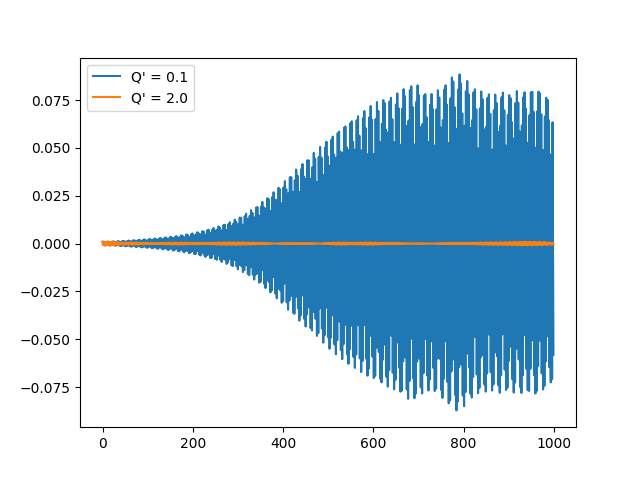

In [39]:
plt.figure()
plt.plot(x_mean, label="Q' = 0.1")
plt.plot(x_mean_high_chroma, label="Q' = 2.0")
plt.legend()